# Clasificación I: El Tapabocas

Debido a la contingencia del COVID el profesor Alexander no quiere salir de su casa, según él, la ciudad no está realizando los exfuerzos suficientes para determinar si las personas estan o no siguiendo el protocol de bioseguridad. Sin embargo, al ver que sus estudiantes del curso de Machine learning ya saben utilizar redes neuronales, él ha decidido utilizar como proyecto el desarrollo de un sistema que permita identificar si las personas estan utilizando o no el tapabocas, por medio de fotografias.

Para la realización de este proyecto el estudiante debera:

1. Crear una base de datos con fotografias donde diferentes personas esten utilizando y no esten utilizando tapabocas. Aqui debe tener en cuenta dos cosas:
    * Tenga en cuenta que una red aprende con base en la información que le proporcionemos, asi que al crear la base de datos tenga en cuenta todas las posibilidades que se imaginen de como podrian estar esas fotos.
    * Si tenemos imagenes muy grandes esto requerira de una red muy grande que puede tardar mucho tiempo en entrenar. Tenga en cuenta ensto por si es necesario procesar las imagenes antes de ingresarlas a la red.   
2. Definir las arquitecturas de red que debe probar.
3. Escoger la red que mejor se desempeñe.
4. Evaluar el rendimiento de la red.


Tenga en cuenta que todo el procedimiento debe ser lo mas amigable para probar. Es decir si el profesor Alexander quiere probar una foto, entonces él solo deberia ingresar la foto en una función la cual se encargue de hacer todo el procesamiento y proporcionar como salida si la persona tiene o no tapabocas.

Además el profesor quiere que contesten las siguientes preguntas:

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

## Qué se debe entregar:

Par ala entrega del proyecto deben porporcionar:

1. La base de datos generada.
2. Un notebook de Jupyter donde presentan todo el pipeline para el entrenamiento de la red. Cada parte debe ser explicada.
3. El notebook debe incluir una función que permita ingresar una muestra de entrada y se proporcione la salida, sin mas pasos intermedios. Por lo tanto en esta función se debe tener en cuenta el acondicionamiento de los datos, antes de ser introducidos en la red neuronal par arealizar las predicciones.
4. El notebook debe incluir las respuestas a las preguntas planteadas.

## Librerías a usar

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from PIL import Image
from pathlib import *

Buscamos bases de datos que ya tuvieron un monto importante de imagenes que nos sirvieran para entrenar la red neuronal, de esta manera encontramos un repositorio que nos proporcionaba una cantidad significativa de imagenes de gente con tapabocas bien/mal puesto.
Asimismo, incrementamos esa base de datos con imagenes de personas con tapabocas de diferentes colores para que la red tambien se entrenara con esos datos.

Recopilamos alrededor de 7000 imagenes que pueden encontrarse en este repositorio creado por nosotros, y para no tener que cargar la carpeta al eaulas


Repositorio de imagenes: https://github.com/Juliansrami99/Imagenes_proyecto2

Base de datos : https://github.com/cabani/MaskedFace-Net

## Cargando Imagenes

In [8]:
current_dir = Path.cwd()
dir_images = current_dir /'Images'
data_dir1 = current_dir /'Images' / 'Correctas'
correct_data = Path(data_dir1)
data_dir2 = current_dir /'Images' / 'Incorrectas'
incorrect_data = Path(data_dir1)

In [9]:
image_count = len(list(data_dir1.glob('*.jpg')))
image_count_i = len(list(data_dir2.glob('*.jpg')))
print(f" Imagenes de personas con tapabocas es {image_count}")
print(f" Imagenes de personas sin tapabocas es {image_count_i}")

 Imagenes de personas con tapabocas es 1911
 Imagenes de personas sin tapabocas es 1883


In [11]:
correct_mask = list(data_dir1.glob('*.jpg'))
#original_image PIL.Image.open(str(correct_mask[0])).size

Proporcionamos parametros predefinidos para crear las redes neuronales que se entrenaran

In [12]:
# Hyperparametro que define el numero de muestras a probar antes de actualizar los parametros internos
batch_size = 32
# Altura de la imagen
img_height = 200
# Anchura de la imagen
img_width = 200

Usaremos el 80% de las imágenes para entrenamiento y el 20% para validación.

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  # Cargamos imagenes  
  dir_images,
  # Validacion 20%
  validation_split=0.2,
  subset="training",
  # Semilla para hacer el experimento aleatorio
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3794 files belonging to 2 classes.
Using 3036 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_images,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3794 files belonging to 2 classes.
Using 758 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['Correctas', 'Incorrectas']


## Visualizacion de datos

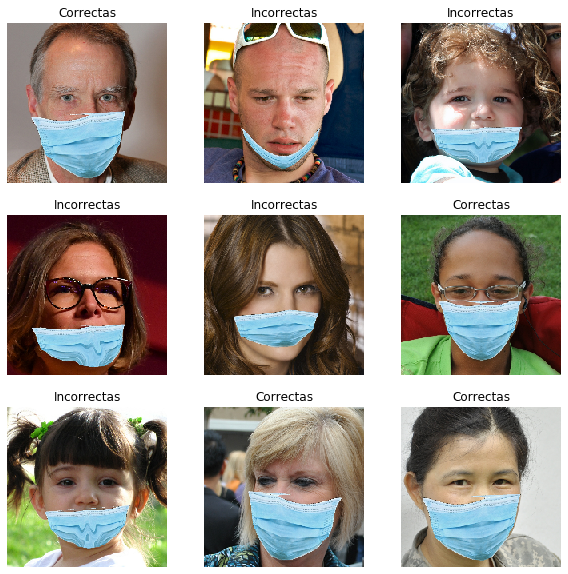

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [28]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 200, 200, 3)
(32,)


image_batch es un tensor de la forma (32,200, 200, 3) . Se trata de un lote de 32 imágenes de forma 180x180x3 (la última dimensión se refiere a los canales de color RGB). label_batch es un tensor de la forma (32,) , estas son etiquetas correspondientes a las 32 imágenes.

## Estandarizar los datos

Los valores del canal RGB están en el rango [0, 255] . Esto no es ideal para una red neuronal; en general, debe tratar de hacer que sus valores de entrada sean pequeños. Aquí, estandarizaremos los valores para que estén en [0, 1] usando una capa de reescalamiento.

In [36]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

Vamos agregar esta caa en el modelo para simplificar su implementación


## Configurar el conjunto de datos para el rendimiento

Asegurémonos de utilizar la captación previa en búfer para que podamos generar datos desde el disco sin que la E / S se bloquee. Estos son dos métodos importantes que debe utilizar al cargar datos.

`.cache()` mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear una caché en disco de alto rendimiento.

`.prefetch()` superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Entrenamiento Modelo 1 (Red Convolucional CNN)

Las redes convolucionales son capaces de identificar las dependeencias espaciales y temporales de la imagen a traves de ciertos filtros. Eso crea canales de kernel que resultan de un proceso de convolución. La idea de estas convoluciones es extraer propiedades como los bordes de una imagen. Convencionalmente la primera capa detecta propiedades como bordes, color y orientacion del gradiente de la imagen, esto sucede en **Conv2D**. Despues cuando se van agregando capas se adaptan propiedades de nivel alto. La capa de Polling se encarga de reducir el tamaño espacial a estudiar. Esto es reduce la dimensionalidad de la matriz que va pasando por la red. En este caso se utiliza **Max Pooling** que retorna el valor maximo de la porcion de la imagen cubierta por el kernel resultante de la convolución de Pooling. Proponemos nuestro primer modelo

In [72]:
num_classes = 2

model1 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [73]:
model1.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

El modelo toma cierto tiempo en entrenarse se podria aumentar el numero de epochs, pero se demoraria mucho en entrenar. Se realizo en su momento con mas epocas, mas adelante mostramos un ejemplo.

In [74]:
model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

95/95 [==============================] - 182s 2s/step - loss: 0.6566 - accuracy: 0.7073 - val_loss: 0.0604 - val_accuracy: 0.9776


In [76]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 23, 23, 32)       

## Evaluar Exactitud

In [77]:
test_loss, test_acc = model1.evaluate(val_ds, verbose=2)
print('\nTest accuracy:', test_acc)

24/24 - 6s - loss: 0.0604 - accuracy: 0.9776

Test accuracy: 0.9775725603103638


## Modelo 2 (Modelo Base)

Se realiza el modelo visto en clase.

In [42]:
num_classes = 2
model2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(3, activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [44]:
model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
95/95 [==============================] - 96s 997ms/step - loss: 0.7761 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 2/3
95/95 [==============================] - 89s 936ms/step - loss: 0.6932 - accuracy: 0.5051 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 3/3
95/95 [==============================] - 99s 1s/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6934 - val_accuracy: 0.4921


In [45]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 940899    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8         
Total params: 941,803
Trainable params: 941,803
Non-trainable params: 0
________________________________________________

## Exactitud Modelo 2

In [47]:
test_loss, test_acc = model2.evaluate(val_ds, verbose=2)
print('\nTest accuracy:', test_acc)

24/24 - 6s - loss: 0.6934 - accuracy: 0.4921

Test accuracy: 0.49208444356918335


A comparación de la red neuronal convulicional, en este caso tenemos menos accuracy resultando así en un modelo con menores resultados.

## Modelo 3 ( Red CNN Simple)

Planteamos un modelo igual que le primero pero mas simple pero aumentandole el número de epochs,para ver si su precision no disminuye mucho.

In [49]:
num_classes = 2
model3 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(3, activation='relu'),
  layers.Dense(num_classes)
])

In [50]:
model3.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [51]:
%%time
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
95/95 [==============================] - 81s 853ms/step - loss: 0.6926 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 2/5
95/95 [==============================] - 76s 804ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 3/5
95/95 [==============================] - 84s 891ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6934 - val_accuracy: 0.4921
Epoch 4/5
95/95 [==============================] - 84s 882ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6934 - val_accuracy: 0.4921
Epoch 5/5
95/95 [==============================] - 82s 870ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6935 - val_accuracy: 0.4921
Wall time: 6min 48s


In [53]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 940899    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 8         
Total params: 941,803
Trainable params: 941,803
Non-trainable params: 0
________________________________________________

## Exactitud del modelo 3

In [54]:
test_loss, test_acc = model3.evaluate(val_ds, verbose=2)
print('\nTest accuracy:', test_acc)

24/24 - 4s - loss: 0.6935 - accuracy: 0.4921

Test accuracy: 0.49208444356918335


El modelo no pasa de 0.5 de precision

#### Modelo con mejor comportamiento.

Finalmente se concluye que el mejor modelo es el primero.

## Prediccion Imagenes Reales

### Identificar si la clase 0 hace referencia a un tapabocas puesto correcta o incorrectamente

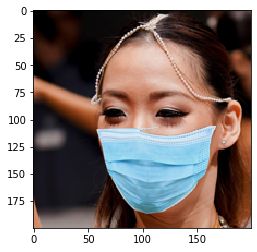

In [55]:
numero_im = 0
real_correct_mask = list(data_dir1.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_im]))
size = (200,200)
prueba1 = prueba1.resize(size)
prueba1 = np.array(prueba1)
plt.imshow(np.array(prueba1))

Expandimos una dimension para que la red la pueda real correctamente

In [56]:
prueba1 = tf.convert_to_tensor(prueba1, dtype=tf.float32)
prueba1 = tf.expand_dims(prueba1, 0)
prueba1.shape

TensorShape([1, 200, 200, 3])

In [57]:
predictions = model1.predict(prueba1)
np.argmax(predictions[0])

0

La clase 1 corresponde a que tiene mal puesto el tapabocas

Cargamos la imagenes de Prueba y definimos la funcion que leera las imagenes y las clasficara. Note que la imagen que recibe debe ser abierta utilizando PIL.Image.open

In [78]:
def clasificacion(prueba1):
    size = (200,200)
    prueba1 = prueba1.resize(size)
    prueba1 = np.array(prueba1)
    plt.imshow(np.array(prueba1))
    
    prueba1 = tf.convert_to_tensor(prueba1, dtype=tf.float32)
    prueba1 = tf.expand_dims(prueba1, 0)
    predictions = model1.predict(prueba1)
    clas = np.argmax(predictions[0])
    if clas == 0:
        print("La red clasifica que tiene tapabocas puesto correctamente")
    elif clas ==1:
        print("La red clasifica que no tiene tapabocas puesto correctamente")
    return

In [59]:
data_dir3 = current_dir /'Images/Prueba'
correct_data = Path(data_dir3)

## Prueba Imagen 1

La red clasifica que tiene tapabocas puesto correctamente


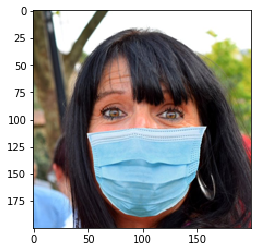

In [60]:
numero_i = 0
real_correct_mask = list(data_dir3.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_i]))
clasificacion(prueba1)

## Prueba Imagen 2

La red clasifica que tiene tapabocas puesto correctamente


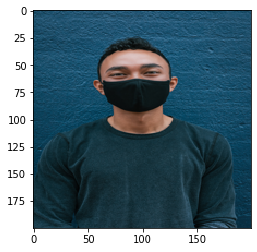

In [79]:
numero_i = 1
real_correct_mask = list(data_dir3.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_i]))
clasificacion(prueba1)

## Prueba Imagen 3

La red clasifica que no tiene tapabocas puesto correctamente


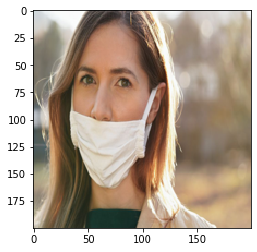

In [63]:
numero_i = 2
real_correct_mask = list(data_dir3.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_i]))
clasificacion(prueba1)

## Prueba Imagen 4

La red clasifica que no tiene tapabocas puesto correctamente


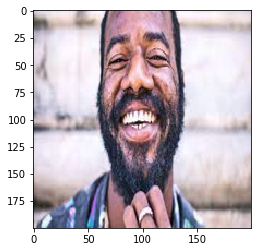

In [64]:
numero_i = 3
real_correct_mask = list(data_dir3.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_i]))
clasificacion(prueba1)

## Prueba Imagen 5

La red clasifica que no tiene tapabocas puesto correctamente


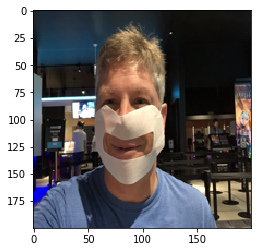

In [65]:
numero_i = 4
real_correct_mask = list(data_dir3.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_i]))
clasificacion(prueba1)

## Prueba Imagen 6

La red clasifica que no tiene tapabocas puesto correctamente


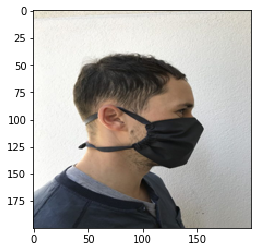

In [66]:
numero_i = 5
real_correct_mask = list(data_dir3.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_i]))
clasificacion(prueba1)

Con la fotos de perfil no encontramos adecuada la clasificacion dado que la red se entreno con fotos frontales. Esto sería algo que se podría añadir en caso de mejorar este trabajo.

## Prueba Imagen 7

La red clasifica que tiene tapabocas puesto correctamente


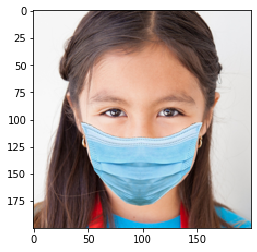

In [103]:
numero_i = 6
real_correct_mask = list(data_dir3.glob('*.jpg'))
prueba1 = PIL.Image.open(str(real_correct_mask[numero_i]))
clasificacion(prueba1)

### Preguntas

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?

Aunque la red fue entrenada con tapabocas falsos, la red es capaz de captar la idea fundamental de entender que se tiene que fijar de la nariz hacia la papada de la cara para detectar si tiene o no tapabocas. Los datos proporcionados fueron imagenes de 1024x10024 que fueron necesarios reducir a 200x200 para que la red no fuera tan pesada.

2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?

Se utilizo la precision de la red tanto en entrenamiento como en el testeo. Asi mismo se eligio una red que fue creada para trabajar especificamente sobre imagenes y trabajar con propiedades de estas imagenes que facilitasen la deteccion del tapabocas. El mejor modelo fue el inicialmente planteado.

3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?

Sorprendentemente la red es capaz de detectar en todos los casos de prueba correctamente de fotos frontales. Uno esperaria que se genere cierto error en fotos reales, pero incluso en fotos reales termina prediciendo muy bien. Incluso es capaz de detectar no solo tapabocas de un color como fue entrenado, si no tambien de otros colores como negro, visto en la imagen de prueba 2.

4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

El modelo puede estar bien. Sin embargo se podria entrenar con fotos diferentes a frontales para que prediga estos casos de mejor manera. Tal vez una mejor manera es preprocesar las imagenes con filtros o convoluciones especificas que uno crea que el modelo pueda detectar facilmente como bordes y así se podría llegar a un modelo mucho mas simple pero igual de fuerte prediciendo.

## Referencias

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53